# Orbits
An orbit is an ellipse in the plane with one focus at the origin. 
An observed orbit is a finite set of points sampled from an orbit.
This program generates unions of randomly observed orbits, and classifies them by how many ellipses are present.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, BettiCurve, PersistenceImage
from gtda.plotting import plot_diagram, plot_point_cloud

from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [3]:
def Rotate(phi): return np.array([[np.cos(phi), -np.sin(phi)],
                                  [np.sin(phi), np.cos(phi)]])

(3, 20, 2)


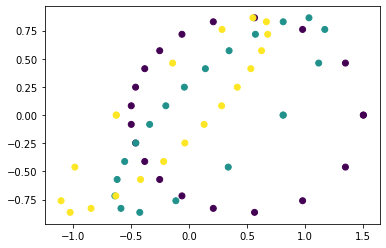

In [4]:
numAng = 3
numExamples = 20

X_train = np.array([[
        [(1-0.25)/(1-np.cos(t)/2) * np.cos(t-n), (1-0.25)/(1-np.cos(t)/2) * np.sin(t)] 
        for t in np.linspace(0,2*np.pi,numExamples)] 
    for n in range(numAng)])
print(X_train.shape)
#plot_point_cloud(X_train.reshape(100,2))

plt.scatter(*np.transpose(X_train.reshape(numAng*numExamples,2)), c=np.sort(np.array(list(range(numAng))*numExamples)))

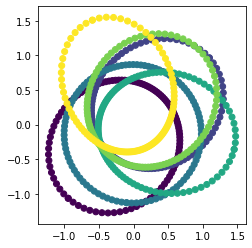

In [5]:
numThetas = 100

def generateExample(numEllipses):
    Thetas = np.linspace(0,2*np.pi, numThetas)
    Angles = np.random.uniform(0,2*np.pi, numEllipses)
    Eccens = get_truncated_normal(0.5,0.5,0,1).rvs(numEllipses)

    PointCloud = np.array([[
            np.dot(Rotate(Angles[n]), (1-Eccens[n]**2)/(1-np.cos(t)*Eccens[n])*np.array([np.cos(t), np.sin(t)])) 
            for t in Thetas] 
        for n in range(numEllipses)])

    #Concatenating
    return PointCloud.reshape(-1, 2)

def generateExamples(numEllipses, numExamples):
    return [generateExample(numEllipses) for k in range(numExamples)]

X_train = generateExample(6)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')

plt.scatter(*np.transpose(X_train), c=np.sort(np.array(list(range(6))*numThetas)))

In [8]:
numTrain = 100
numTest  = 30
classes = [1,2,3,4]

X_train, X_test = [], []
for i in classes: 
    X_train += generateExamples(i, numTrain)
    X_test  += generateExamples(i, numTest)
    
Y_train = np.sort(np.array(classes*numTrain))
Y_test  = np.sort(np.array(classes*numTest))

print(np.array(X_train[19]).shape)

(100, 2)


# Constructing Diagrams
## w/ sample diagrams of each class

(400, 581, 3) (120, 537, 3)


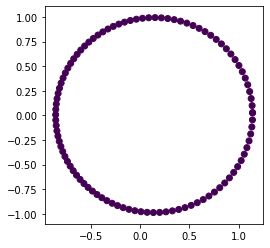

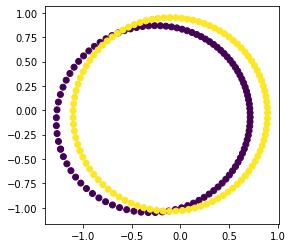

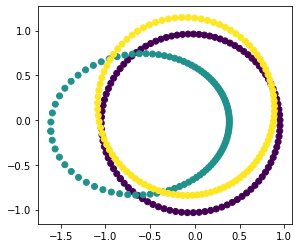

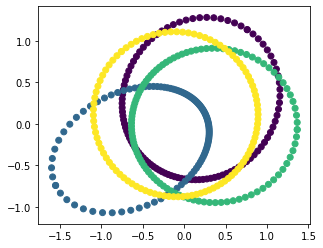

In [9]:
VR = VietorisRipsPersistence(
    metric='euclidean', max_edge_length=1, homology_dimensions=(0,1))

train_diagrams = VR.fit_transform(X_train)
test_diagrams  = VR.transform(X_test)
print(train_diagrams.shape, test_diagrams.shape)

fig = plt.figure()

sample=1
for i in classes:
    plot_diagram(train_diagrams[100*(i-1)+sample])
    ax = fig.add_subplot(i,1,1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(*np.transpose(X_train[100*(i-1)+sample]),c=np.sort(np.array(classes[:i]*numThetas)))
    plt.show()

# Classification with Sklearn
## 1. Persistence Entropy

In [10]:
PE = PersistenceEntropy()
E_train = PE.fit_transform(train_diagrams)
E_test  = PE.transform(test_diagrams)

#Try betti curves, normalize diagrams; persistence images

In [11]:
plot_point_cloud(E_train)

In [12]:
LR = LogisticRegression(solver = 'lbfgs', max_iter=1000)
LR.fit(E_train, Y_train)
LR.score(E_test, Y_test)

0.9

## 2. Betti Curves

In [13]:
BC = BettiCurve()
B_train = BC.fit_transform(train_diagrams)
B_test  = BC.transform(test_diagrams)

In [15]:
print(B_train.shape)
BC1 = B_train[:,1,:]
plot_point_cloud(BC1)
print(BC1.shape)

(400, 2, 100)


(400, 100)


In [16]:
LR2 = LogisticRegression(solver = 'lbfgs', max_iter=5000)
LR2.fit(B_train[:,0,:], Y_train)
LR2.score(B_test[:,0,:], Y_test)

C:\Users\openb\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9666666666666667

## 3. Persistence Images

In [17]:
PI = PersistenceImage()
P_train = PI.fit_transform(train_diagrams)
P_test  = PI.transform(test_diagrams)

In [18]:
print(P_train.shape)
nsamples_train, nchannels, nx, ny = P_train.shape
nsamples_test,  _, _, _ = P_test.shape
PI.plot(P_train, homology_dimension_ix=1)
inP_train = P_train[:,1,:,:].reshape((nsamples_train, nx*ny))
inP_test  = P_test[:,1,:,:].reshape((nsamples_test, nx*ny))

(400, 2, 100, 100)


In [19]:
LR3 = LogisticRegression(solver = 'lbfgs', max_iter=5000)
LR3.fit(inP_train, Y_train)
LR3.score(inP_test, Y_test)

0.5916666666666667